# Harmful Algae Bloom (HAB) vs Water Level Changes near St. Pete FL Coastal Area

**Intro to dataset**

**Sources:**
<ul>
    <li>https://iris.who.int/bitstream/handle/10665/42591/9241545801.pdf?sequence=1</li>
    <li>https://tidesandcurrents.noaa.gov/waterlevels.html?id=8726520</li>
    <li>https://geodata.myfwc.com/datasets/myfwc::recent-harmful-algal-bloom-hab-events/about</li>
</ul>

***

# 1. Import Python libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
from scipy import stats
import folium
import pytz
import datetime
from dateutil import parser

***

# 2. Import datasets
### FWC Harmful Algae Blooms (HAB) dataset

In [2]:
hab = pd.read_csv("hab.csv")

In [3]:
print(hab.shape)

(86163, 13)


### NOAA St. Petersburg Station Water Level datasets

In [4]:
# Added rolling mean & rolling stdev fields to spreadsheets before import
pete_22 = pd.read_csv('st pete water levels 2022.csv', na_values='#DIV/0!')
pete_21 = pd.read_csv('st pete water levels 2021.csv', na_values='#DIV/0!')
pete_20 = pd.read_csv('st pete water levels 2020.csv', na_values='#DIV/0!')
pete_19 = pd.read_csv('st pete water levels 2019.csv', na_values='#DIV/0!')
pete_18 = pd.read_csv('st pete water levels 2018.csv', na_values='#DIV/0!')
pete_17 = pd.read_csv('st pete water levels 2017.csv', na_values='#DIV/0!')
pete_16 = pd.read_csv('st pete water levels 2016.csv', na_values='#DIV/0!')
pete_15 = pd.read_csv('st pete water levels 2015.csv', na_values='#DIV/0!')

pete2 = pd.concat([pete_15, pete_16, pete_17, pete_18, pete_19, pete_20, pete_21, pete_22], sort=True)

In [5]:
print(pete2.shape)

(70128, 9)


***

# 3. Data Cleansing

## HAB dataset

In [6]:
# Add column converting cell count/L to cell count/mL
hab['cell_count_ml'] = hab['COUNT_'] / 1000

# Transform SAMPLE_DATE to datetime
hab['SAMPLE_DATE'] = hab['SAMPLE_DATE'].str[:10]
hab['date_time'] = hab['SAMPLE_DATE'] + ' ' + hab['TIME']
hab['date_time'] = pd.to_datetime(hab['date_time'])
hab['date_time_hour'] = hab['date_time'].dt.round('60min')

# Create "time of day" field
time_conditions = [
    (hab['TIME'] >= '00:00:00') & (hab['TIME'] < '06:00:00'),
    (hab['TIME'] >= '06:00:00') & (hab['TIME'] < '12:00:00'),
    (hab['TIME'] >= '12:00:00') & (hab['TIME'] < '18:00:00'),
    (hab['TIME'] >= '18:00:00') & (hab['TIME'] < '23:59:59')]
time_values = ['earlymorning', 'morning','afternoon', 'night']
hab['time_of_day'] = np.select(time_conditions, time_values)

# Drop NA times
hab = hab.dropna(subset=['TIME','date_time_hour'])

# Convert timezones to EST
gmt = pytz.timezone('GMT')
est = pytz.timezone('US/Eastern')
cst = pytz.timezone('US/Central')
date = datetime.datetime.strptime('2015-01-01 00:00:00', '%Y-%m-%d %H:%M:%S')
dategmt = gmt.localize(date)
dateeastern = dategmt.astimezone(est)
datecst = cst.localize(date)
dateeastern2 = datecst.astimezone(est)

hab['date_time_adj'] = hab['date_time_hour'].astype(str) + hab['TIMEZONE']
hab['date_time_adj'] = hab['date_time_adj'].str.replace('GMT','+00:00')
hab['date_time_adj'] = hab['date_time_adj'].str.replace('CST','-06:00')
hab['date_time_adj'] = hab['date_time_adj'].str.replace('CDT','-06:00')
hab['date_time_adj'] = hab['date_time_adj'].str.replace('EST','-05:00')
hab['date_time_adj'] = hab['date_time_adj'].str.replace('EDT','-05:00')
hab['date_time_est'] = pd.to_datetime(hab['date_time_adj'], utc=True)
hab['date_time_est'] = hab['date_time_est'].dt.tz_convert('US/Eastern')
hab['date_time_est'] = hab['date_time_est'].dt.tz_localize(tz=None)

# Add separate columns for datetime components
hab['month'] = hab['date_time_est'].dt.month
hab['year'] = hab['date_time_est'].dt.year
hab['month'] = hab.month.astype('Int64')
hab['year'] = hab.year.astype('Int64')
hab['month_of_year'] = pd.to_datetime(hab['date_time_est']).dt.to_period('M')
hab = hab.dropna(subset=['date_time_est'])

# Add levels of HABs by risk
count_condition = [
    (hab['cell_count_ml'] < 3000),
    (hab['cell_count_ml'] >= 3000) & (hab['cell_count_ml'] < 20000),
    (hab['cell_count_ml'] >= 20000) & (hab['cell_count_ml'] < 100000),
    (hab['cell_count_ml'] >= 100000)]
count_value = ['no risk', 'low risk', 'med risk', 'high risk']
hab['risk_level'] = np.select(count_condition, count_value)

hab_condition = [
    (hab['risk_level'] == 'med risk') | (hab['risk_level'] == 'high risk'),
    (hab['risk_level'] == 'low risk')]
hab_value = [1, 0]
hab['risk_level_int'] = np.select(hab_condition, hab_value)

# Sort columns
hab = hab.sort_values('date_time_est')

# Add bool column for HAB events
hab['hab_event_int'] = np.where(hab['cell_count_ml'] >= 3000, 1, 0)

# Limit observations to St. Pete, FL locations
hab = hab[hab['LATITUDE'] >= 27.000000]
hab = hab[hab['LATITUDE'] <= 28.500000]
hab = hab[hab['LONGITUDE'] >= -84.000000]
hab = hab[hab['LONGITUDE'] <= -82.000000]

# Drop columns
hab = hab.drop(['X', 'Y', 'date_time_hour', 'date_time_adj', 'date_time', 'SAMPLE_DATE', 'TIME', 'COUNT_'], axis=1)

In [7]:
print(hab.describe())

           OBJECTID         DEPTH      LATITUDE     LONGITUDE  cell_count_ml  \
count  2.992500e+04  29851.000000  29925.000000  29925.000000   29925.000000   
mean   1.058138e+07      1.660202     27.517264    -82.657196     184.574837   
min    1.053589e+07      0.000000     27.000630    -83.998333       0.000000   
25%    1.055804e+07      0.500000     27.311000    -82.722500       0.000000   
50%    1.058544e+07      0.500000     27.484050    -82.612930       0.000000   
75%    1.060342e+07      0.500000     27.759803    -82.565300       0.000000   
max    1.062205e+07     51.000000     28.499967    -82.022370  388400.000000   
std    2.549386e+04      4.631677      0.320862      0.191740    3029.863578   

                       date_time_est     month         year  risk_level_int  \
count                          29925   29925.0      29925.0    29925.000000   
mean   2019-12-10 15:28:11.909774336  6.556992  2019.438797        0.001704   
min              2015-01-02 17:00:00      

In [8]:
print(hab.info())

<class 'pandas.core.frame.DataFrame'>
Index: 29925 entries, 242 to 86085
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   OBJECTID        29925 non-null  int64         
 1   TIMEZONE        29925 non-null  object        
 2   DEPTH           29851 non-null  float64       
 3   LOCATION        29923 non-null  object        
 4   LATITUDE        29925 non-null  float64       
 5   LONGITUDE       29925 non-null  float64       
 6   NAME            29925 non-null  object        
 7   HAB_ID          29925 non-null  object        
 8   cell_count_ml   29925 non-null  float64       
 9   time_of_day     29925 non-null  object        
 10  date_time_est   29925 non-null  datetime64[ns]
 11  month           29925 non-null  Int64         
 12  year            29925 non-null  Int64         
 13  month_of_year   29925 non-null  period[M]     
 14  risk_level      29925 non-null  object        
 15  risk_

## St. Pete Water Level dataset

In [9]:
# Convert GMT dates to EST
gmt = pytz.timezone('GMT')
est = pytz.timezone('US/Eastern')
time = '2023-01-01 00:00:00'
date = datetime.datetime.strptime(time, '%Y-%m-%d %H:%M:%S')
dategmt = gmt.localize(date)
dateeastern = dategmt.astimezone(est)

pete2['date_time'] = pete2['Date'] + ' ' + pete2['Time (GMT)']
pete2['date_time'] = pd.to_datetime(pete2['date_time'])
pete2['date_time_est'] = pd.to_datetime(pete2['date_time'], utc=True).dt.tz_convert('US/Eastern')
pete2['date_time_est'] = pete2['date_time_est'].dt.tz_localize(tz=None)

# Rename columns
pete2 = pete2.rename(columns={'RollStdev ft 1 day':'RollStdev 1 day'})

# Convert objects to floats
pete2['RollStdev 1 day'] = pete2['RollStdev 1 day'].astype(float)
pete2['RollStdev 1 week'] = pete2['RollStdev 1 week'].astype(float)

# Sort columns
pete2 = pete2.sort_values('date_time_est')

# Add datetime components
pete2['month'] = pete2['date_time_est'].dt.month
pete2['year'] = pete2['date_time_est'].dt.year
pete2['month'] = pete2.month.astype('Int64')
pete2['year'] = pete2.year.astype('Int64')
pete2['month_of_year'] = pd.to_datetime(pete2['date_time_est']).dt.to_period('M')

# Add Ft Off Avg column for how far off average a given water level is
avg_wl = pete2['Verified (ft)'].mean() # 1.621160296634341
pete2['ft_off_avg'] = pete2['Verified (ft)'] - 1.621160296634341

# Drop columns & rows
pete2 = pete2.drop(['date_time'], axis=1)
pete2 = pete2.drop_duplicates(subset=['date_time_est'])

In [10]:
print(pete2.describe())

       Predicted (ft)  RollStdev 1 week  RollStdev 1 day  Rolling mean 1 day  \
count    70120.000000      70112.000000     70112.000000        70120.000000   
mean         1.200685          0.731642         0.682395            1.621057   
min         -1.106000          0.014142         0.014142           -2.021250   
25%          0.718000          0.648666         0.571029            1.383750   
50%          1.271000          0.717105         0.674456            1.652500   
75%          1.704000          0.796459         0.783960            1.887500   
max          3.076000          1.692127         2.631902            4.157083   
std          0.725799          0.126831         0.154767            0.430201   

       Rolling mean 1 week  Verified (ft)                  date_time_est  \
count         70120.000000   70120.000000                          70120   
mean              1.621893       1.621160  2018-12-31 18:48:32.036508928   
min               0.473155      -3.920000          

In [11]:
print(pete2.info())

<class 'pandas.core.frame.DataFrame'>
Index: 70120 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Date                 70120 non-null  object        
 1   Predicted (ft)       70120 non-null  float64       
 2   Preliminary (ft)     70120 non-null  object        
 3   RollStdev 1 week     70112 non-null  float64       
 4   RollStdev 1 day      70112 non-null  float64       
 5   Rolling mean 1 day   70120 non-null  float64       
 6   Rolling mean 1 week  70120 non-null  float64       
 7   Time (GMT)           70120 non-null  object        
 8   Verified (ft)        70120 non-null  float64       
 9   date_time_est        70120 non-null  datetime64[ns]
 10  month                70120 non-null  Int64         
 11  year                 70120 non-null  Int64         
 12  month_of_year        70120 non-null  period[M]     
 13  ft_off_avg           70120 non-null  

## Merge datasets for analysis

In [12]:
hab_wl = pete2.merge(hab, on=['date_time_est', 'year', 'month', 'month_of_year'], how='left', suffixes=('_wl', '_hab'), validate='1:m')
hab_wl_counted = hab_wl.groupby('year').agg({'cell_count_ml':'sum'})
hab_wl_sorted = hab_wl_counted.sort_values('cell_count_ml', ascending=False)
hab_wl['quarter'] = pd.to_datetime(hab_wl['date_time_est']).dt.to_period('Q')

## Variables for analyzing data

In [13]:
# Variables
hab_events = hab[hab['cell_count_ml'] > 3000]
hab_wl_2018 = hab_wl[hab_wl['date_time_est'] >= '2018-01-01']
hab_events_wl = hab_wl[hab_wl['cell_count_ml'] > 3000]
med_high_risk = hab_wl[(hab_wl['risk_level'] == 'med risk') | (hab_wl['risk_level'] == 'high risk')]
no_low_risk = hab_wl[(hab_wl['risk_level'] == 'low risk') | (hab_wl['risk_level'] == 'no risk')]
low_risk = hab_wl[hab_wl['risk_level'] == 'low risk']

***

# 4. Issues for analysis

**There were major harmful algae blooms (HABs) in Q3-Q4 of 2018, 2019, 2021, and 2022 in the St. Pete coastal area. Do unusually high or low water levels correlate to these HABs in a way that lets us predict future HAB events through water level measurements?**

## a. Cell Counts/mL
##### Risk Levels (cell count/mL)
<ol>
    <li>0 - 3k: no risk</li>
    <li>3k - 20k: low risk</li>
    <li>20k - 100k: med risk</li>
    <li>100k+: high risk</li>
</ol>

##### HAB Events (cell count/mL)
<ol>
    <li>0 - 3k: False</li>
    <li>3k+: True</li>
</ol>

## b. Time periods
<ol>
    <li>Years</li>
    <li>Quarter by year</li>
    <li>Month</li>
</ol>

## c. Changes in Water Levels
<ol>
    <li>High vs low water levels</li>
    <li>Changes in water levels by rolling stdev</li>
</ol>

***

# 5. Insights

### a. Correlation between harmful algae bloom (HAB) events and water level changes

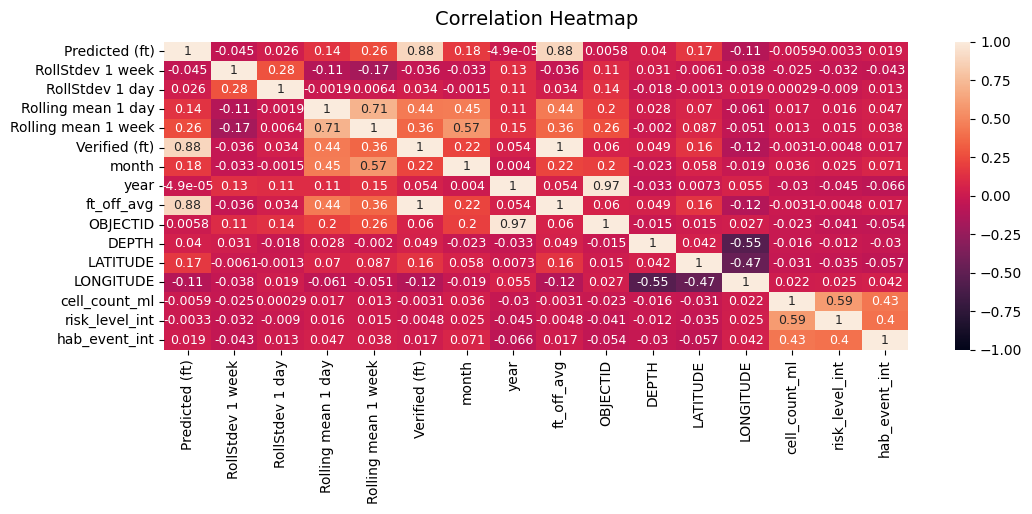

In [14]:
plt.figure(figsize=(12,4))
heatmap = sns.heatmap(hab_wl_2018.corr(numeric_only=True), vmin=-1, vmax=1, annot=True, annot_kws={"size":9})
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12)
heatmap.set_xticklabels(heatmap.get_xmajorticklabels(), fontsize = 10)
heatmap.set_yticklabels(heatmap.get_ymajorticklabels(), fontsize = 10)
plt.show()

**According to the correlation heatmap, water level data does NOT seem to correlate with HAB events.**

&nbsp;

***

### b. Notable harmful algae bloom (HAB) events over time (based on >3,000/mL cell counts)

In [15]:
mean_cell_counts_by_risk_level = hab_wl.groupby('risk_level')['cell_count_ml'].mean().round(2).sort_values(ascending=False)
print(mean_cell_counts_by_risk_level)

risk_level
high risk    287333.33
med risk      34612.36
low risk       7202.99
no risk          53.34
Name: cell_count_ml, dtype: float64


***Distribution of mean cell counts for each risk level.***

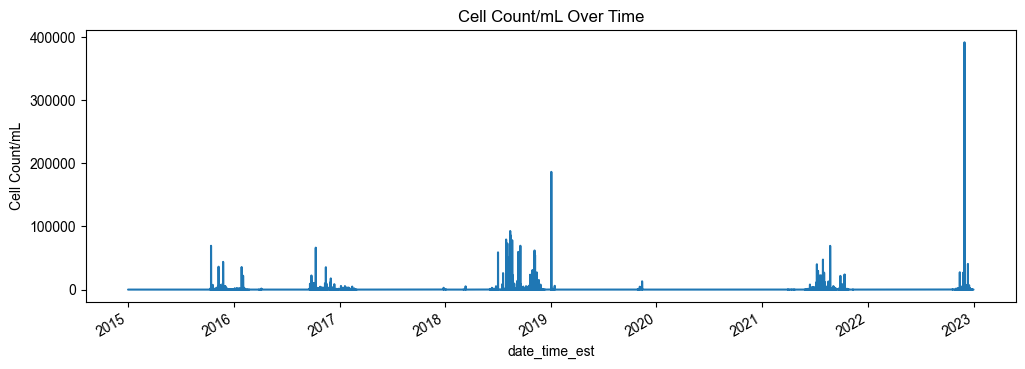

In [16]:
fig, ax = plt.subplots(figsize=(12,4))
sns.set_theme(style='ticks', palette='pastel')
hab_wl.groupby('date_time_est')['cell_count_ml'].sum().plot()
plt.ylabel('Cell Count/mL')
plt.title('Cell Count/mL Over Time')
plt.show()

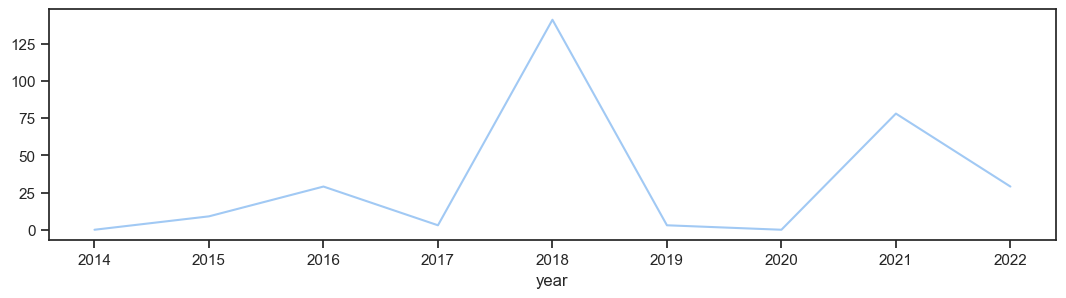

In [17]:
fig, ax = plt.subplots(figsize=(13,3))
hab_wl.groupby('year')['hab_event_int'].sum().plot()
plt.show()

**2018, 2021, and 2022 have the highest counts of HAB events.**

&nbsp;

***

### c. Notable HAB events over time (2018 - 2022)

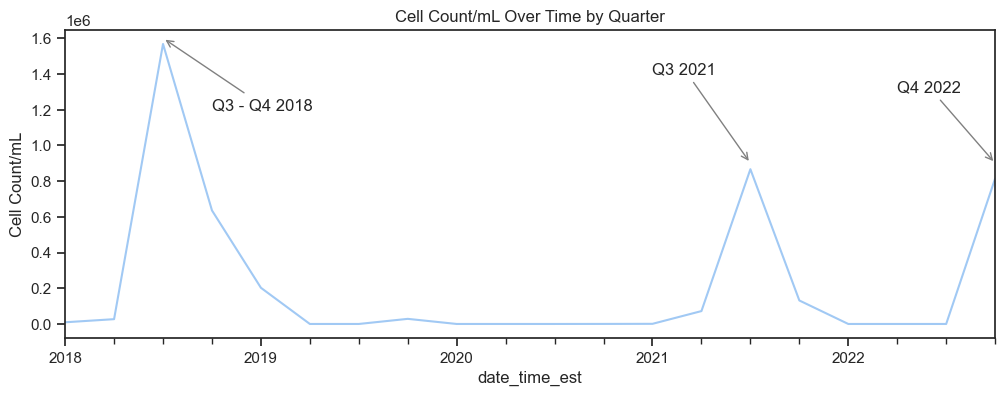

In [18]:
fig, ax = plt.subplots(figsize=(12,4))
sns.set_theme(style='ticks', palette='pastel')
hab_wl_2018.resample('Q', on='date_time_est')['cell_count_ml'].sum().plot()
plt.ylabel('Cell Count/mL')
plt.title('Cell Count/mL Over Time by Quarter')
ax.annotate("Q4 2022", xy=(pd.Timestamp('2022-11'),900000), xytext=(pd.Timestamp('2022-06'), 1300000), arrowprops={'arrowstyle':'->', 'color':'gray'})
ax.annotate("Q3 - Q4 2018", xy=(pd.Timestamp('2018-08'),1600000), xytext=(pd.Timestamp('2018-12'), 1200000), arrowprops={'arrowstyle':'->', 'color':'gray'})
ax.annotate("Q3 2021", xy=(pd.Timestamp('2021-09'),900000), xytext=(pd.Timestamp('2021-03'), 1400000), arrowprops={'arrowstyle':'->', 'color':'gray'})
plt.show()

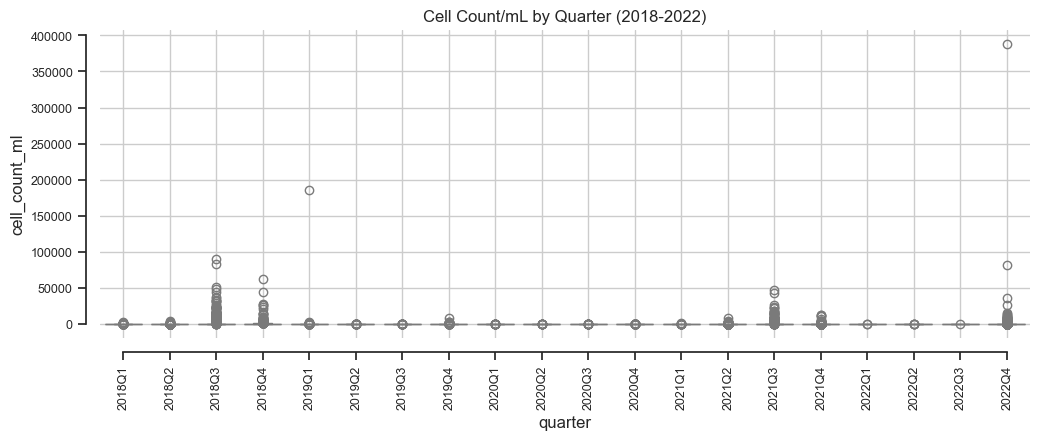

In [19]:
fig, ax = plt.subplots(figsize=(12,4))
sns.set_theme(style='ticks', palette='pastel')
g = sns.boxplot(x='quarter', y='cell_count_ml', data=hab_wl_2018)
sns.despine(offset=10, trim=True)
plt.xticks(rotation=90)
g.tick_params(labelsize=9)
plt.grid()
plt.title('Cell Count/mL by Quarter (2018-2022)')
plt.show()

**Cell count/mL has more outliers and a broader range of outliers in the following quarters:** 
<ol>
    <li>Q3 of 2018</li>
    <li>Q4 of 2018</li>
    <li>Q4 of 2019</li>
    <li>Q3 of 2021</li>
    <li>Q4 of 2022</li>
</ol>

&nbsp;

***

### d. Water level correlation to HAB events

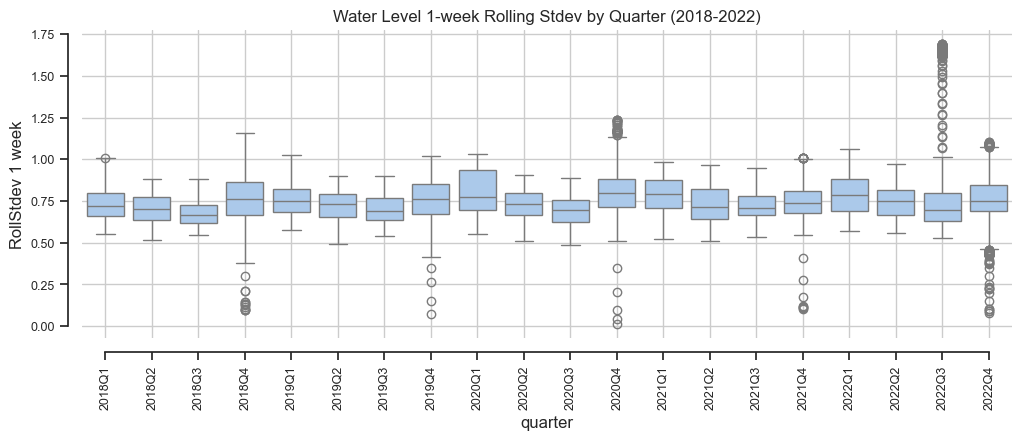

In [20]:
fig, ax = plt.subplots(figsize=(12,4))
sns.set_theme(style='ticks', palette='pastel')
g = sns.boxplot(x='quarter', y='RollStdev 1 week', data=hab_wl_2018)
sns.despine(offset=10, trim=True)
plt.xticks(rotation=90)
g.tick_params(labelsize=9)
plt.grid()
plt.title('Water Level 1-week Rolling Stdev by Quarter (2018-2022)')
plt.show()

**There appears to be some overlap between changes in 1-week rolling stdev and the five quarters listed above that are associated with notable HAB events.**
&nbsp;

&nbsp;

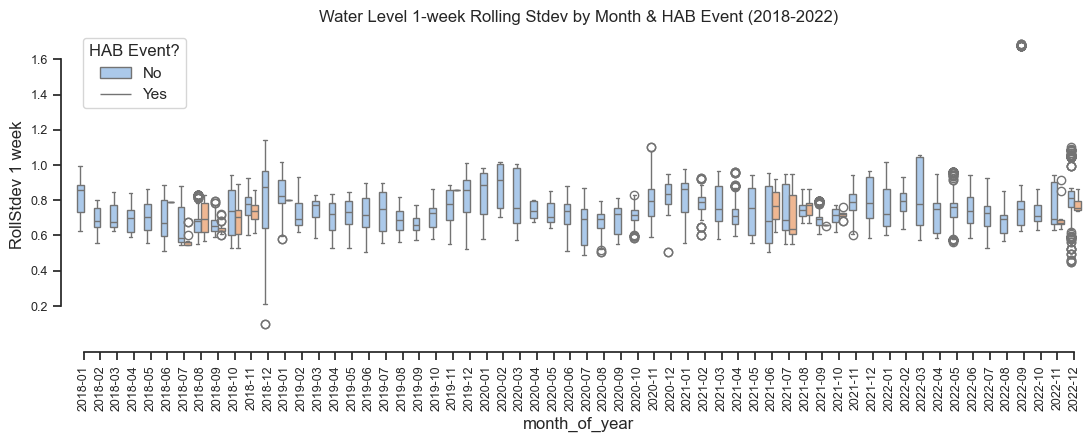

In [21]:
fig, ax = plt.subplots(figsize=(13,4))
sns.set_theme(style='ticks', palette='pastel')
g = sns.boxplot(x='month_of_year', y='RollStdev 1 week', data=hab_wl_2018, hue='hab_event_int')
sns.despine(offset=10, trim=True)
plt.legend(title='HAB Event?', loc='best', labels=['No', 'Yes'])
plt.title('Water Level 1-week Rolling Stdev by Month & HAB Event (2018-2022)')
plt.xticks(rotation=90)
g.tick_params(labelsize=9)
plt.show()

**When we break down 1-week rolling stdevs by whether a HAB event is occurring, we tend to see smaller ranges in stdev values. This is likely due to non-HAB events making up the majority of observations and therefore having more variation in measurements.**

**Visual analysis shows there may be some overlap in seasonality for both HAB events and water level changes, though the relationship is likely NOT causal.**

**This chart also gives a very clear visual of when HAB events occured from 2018-2022, based on the orange box plots.**
&nbsp;

&nbsp;

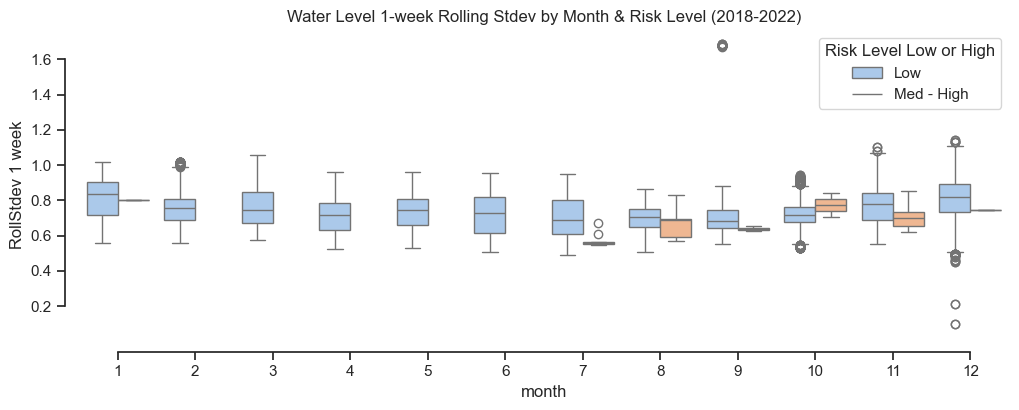

In [22]:
# KEEP
fig, ax = plt.subplots(figsize=(12,4))
sns.set_theme(style='ticks', palette='pastel')
g = sns.boxplot(x='month', y='RollStdev 1 week', data=hab_wl_2018, hue='risk_level_int')
sns.despine(offset=10, trim=True)
plt.legend(title='Risk Level Low or High', labels=['Low', 'Med - High'])
plt.title('Water Level 1-week Rolling Stdev by Month & Risk Level (2018-2022)')
plt.show()

**Breaking down rolling stdev by month and risk level (low risk vs med-high risk) shows that the months that were more likely to have med-high risk HAB events also had more significant outliers in the rolling stdev for water level changes.**

&nbsp;